In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 3
extraNin: int = 0
Ninter: int = 0
Nout: int = 3
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
R_vec_i = 2*np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 2000  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# include_Power: bool = True
include_Power: bool = False
lam = -80**(1)
lam2 = -5*10**(-3)
# lam2 = +10**(-1)  # lambda parameter for penalty on Power dissipation\
# lam = 5.0  # lambda parameter for penalty on Power dissipation

stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 100

## Networkx sizes
scale: float = 50.0
squish: float = 0.01

In [4]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [5]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         include_Power, lam, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [0.5 0.5 0.5]
input M mismatches output and input
no extra input nodes, no noise added
no inter nodes, no noise added
no extra output nodes, no noise added


In [6]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [7]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0 1 2]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [3 4 5]
extraOutput_nodes_arr  []
ground_nodes_arr  [6]


In [8]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [9]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [10]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

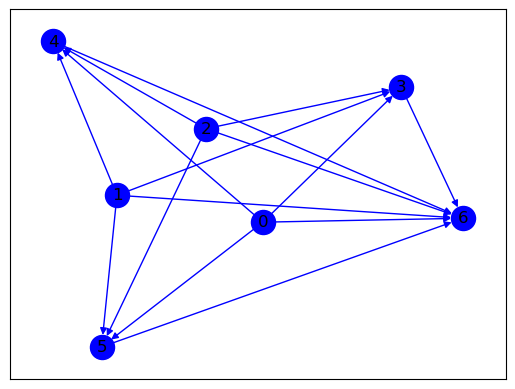

NET is ready


In [11]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [12]:
Strctr.EIEJ_plots

[(0, 3),
 (0, 4),
 (0, 5),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (0, 6),
 (1, 6),
 (2, 6),
 (3, 6),
 (4, 6),
 (5, 6)]

## Train

In [13]:
for i in range(Variabs.iterations):
    print('i', i)
    
#     # if i<(200):
#     if i<(iterations/2):
#         pass
#     else:
#         # Variabs.R_update = 'deltaR_propto_Q'
#         Variabs.lam = lam2
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")
        
    if include_Power:
        State.calc_Power_norm(BigClass)
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        print('loss', State.loss)
        loss_mean = np.mean(np.abs(State.loss), axis=1)
        Variabs.lam = copy.copy(Variabs.lam) * (10**(-7) / loss_mean) ** 0.001
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        # print('p', State.p)
        # print('u', State.u)
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
i 1
k 1
time= 1
loss [[-0.13533356 -0.23576667  0.01989038]
 [-0.16997945 -0.47649122 -0.43731217]]
solving dual problem
updating Rs
i 2
k 2
i 3
k 3
time= 2
loss [[-0.1625638  -0.11224638 -0.24221062]
 [ 0.07760539 -0.16716965 -0.22176105]]
solving dual problem
updating Rs
i 4
k 4
i 5
k 5
time= 3
loss [[ 0.00530262 -0.06601073 -0.16138624]
 [-0.21877474 -0.35233424  0.05301182]]
solving dual problem
updating Rs
i 6
k 6
i 7
k 7
time= 4
loss [[-0.00511129 -0.08275332 -0.1304283 ]
 [-0.04353799 -0.12180016 -0.15262783]]
solving dual problem
updating Rs
i 8
k 8
i 9
k 9
time= 5
loss [[-0.10978099 -0.36195504  0.03060584]
 [-0.09077875 -0.3896776  -0.05754375]]
solving dual problem
updating Rs
i 10
k 10
i 11
k 11
time= 6
loss [[-0.13661823 -0.4784647  -0.1721104 ]
 [-0.11672465 -0.22534875  0.09374341]]
solving dual problem
updating Rs
i 12
k 12
i 13
k 13
time= 7
loss [[-0.01541567 -0.01700396 -0.02391498]
 [ 0.03413161  0.07222345 -0.11118405]]
solving dual problem
updating Rs
i 14


updating Rs
i 148
k 148
i 149
k 149
time= 75
loss [[-0.07832119 -0.10757479  0.19181889]
 [ 0.02147579  0.07581088 -0.08855156]]
solving dual problem
updating Rs
i 150
k 150
i 151
k 151
time= 76
loss [[-0.12959303  0.02260271  0.11915785]
 [-0.05814992 -0.05691789  0.12447894]]
solving dual problem
updating Rs
i 152
k 152
i 153
k 153
time= 77
loss [[ 0.01642387  0.15790784 -0.1700935 ]
 [ 0.0536074  -0.06232362  0.00828297]]
solving dual problem
updating Rs
i 154
k 154
i 155
k 155
time= 78
loss [[-0.00046207  0.15596539 -0.14810645]
 [-0.02822541  0.0877491  -0.04789242]]
solving dual problem
updating Rs
i 156
k 156
i 157
k 157
time= 79
loss [[-0.13034311  0.13725209  0.00667291]
 [ 0.07246416 -0.18414968  0.11247415]]
solving dual problem
updating Rs
i 158
k 158
i 159
k 159
time= 80
loss [[ 0.05827107 -0.11016927  0.0586282 ]
 [ 0.04177321 -0.23125078  0.19541322]]
solving dual problem
updating Rs
i 160
k 160
i 161
k 161
time= 81
loss [[ 0.01769725  0.04272417 -0.0528128 ]
 [ 0.007934

time= 189
loss [[-0.06061554 -0.03310181  0.09576232]
 [ 0.00762479  0.08307503 -0.08772205]]
solving dual problem
updating Rs
i 378
k 378
i 379
k 379
time= 190
loss [[ 0.00498001 -0.01511038  0.01404985]
 [-0.06372422  0.09645078 -0.02928303]]
solving dual problem
updating Rs
i 380
k 380
i 381
k 381
time= 191
loss [[-0.01758468  0.08411728 -0.06249658]
 [-0.06071544 -0.02244047  0.08802887]]
solving dual problem
updating Rs
i 382
k 382
i 383
k 383
time= 192
loss [[-0.01467773 -0.05408042  0.07514002]
 [-0.00855167 -0.03045139  0.04502065]]
solving dual problem
updating Rs
i 384
k 384
i 385
k 385
time= 193
loss [[-0.06130892  0.07721546 -0.01161821]
 [-0.00082081 -0.07760139  0.08381555]]
solving dual problem
updating Rs
i 386
k 386
i 387
k 387
time= 194
loss [[ 0.05732568  0.10719258 -0.16167805]
 [-0.09980159  0.06902036  0.03526672]]
solving dual problem
updating Rs
i 388
k 388
i 389
k 389
time= 195
loss [[-0.06309525 -0.00590343  0.07132279]
 [ 0.12616699  0.03775182 -0.15915423]]


updating Rs
i 604
k 604
i 605
k 605
time= 303
loss [[-0.02287697 -0.00211722  0.03023491]
 [-0.0252418  -0.02287957  0.04907284]]
solving dual problem
updating Rs
i 606
k 606
i 607
k 607
time= 304
loss [[ 0.13301313  0.06670589 -0.19691192]
 [-0.01289041 -0.1141438   0.12920833]]
solving dual problem
updating Rs
i 608
k 608
i 609
k 609
time= 305
loss [[ 0.00321445 -0.22586363  0.22690909]
 [-0.01020672 -0.1887622   0.2017355 ]]
solving dual problem
updating Rs
i 610
k 610
i 611
k 611
time= 306
loss [[ 0.06245445 -0.0978016   0.03912988]
 [-0.00372483 -0.11415659  0.12113554]]
solving dual problem
updating Rs
i 612
k 612
i 613
k 613
time= 307
loss [[ 0.05521563  0.00707228 -0.0606523 ]
 [ 0.10306967  0.15503225 -0.25661452]]
solving dual problem
updating Rs
i 614
k 614
i 615
k 615
time= 308
loss [[-0.00077689 -0.01122188  0.01279819]
 [ 0.09780528  0.05343803 -0.1482174 ]]
solving dual problem
updating Rs
i 616
k 616
i 617
k 617
time= 309
loss [[ 0.05420099 -0.08940919  0.03950048]
 [-0

time= 371
loss [[-0.00252624  0.06255425 -0.05790511]
 [-0.02670462 -0.21129404  0.24209754]]
solving dual problem
updating Rs
i 742
k 742
i 743
k 743
time= 372
loss [[ 0.05681837 -0.18323974  0.12920827]
 [ 0.05464111 -0.09560849  0.04426165]]
solving dual problem
updating Rs
i 744
k 744
i 745
k 745
time= 373
loss [[ 0.04261147 -0.23051073  0.19242845]
 [ 0.02474541 -0.16057365  0.14283173]]
solving dual problem
updating Rs
i 746
k 746
i 747
k 747
time= 374
loss [[ 0.14092472  0.11450042 -0.25130892]
 [ 0.07516506  0.12645791 -0.19871388]]
solving dual problem
updating Rs
i 748
k 748
i 749
k 749
time= 375
loss [[-0.03690769 -0.2362611   0.27728842]
 [-0.05415847 -0.2375003   0.29553449]]
solving dual problem
updating Rs
i 750
k 750
i 751
k 751
time= 376
loss [[ 0.03085075 -0.18283211  0.15791718]
 [ 0.15059069 -0.03633806 -0.11012595]]
solving dual problem
updating Rs
i 752
k 752
i 753
k 753
time= 377
loss [[ 0.08555836 -0.07594355 -0.00483466]
 [ 0.00692986 -0.09325854  0.08964814]]


updating Rs
i 862
k 862
i 863
k 863
time= 432
loss [[ 0.09066414 -0.074158   -0.01113744]
 [ 0.1067327  -0.08090684 -0.02318202]]
solving dual problem
updating Rs
i 864
k 864
i 865
k 865
time= 433
loss [[-0.01861011 -0.05728726  0.07797719]
 [ 0.01445655 -0.15458409  0.14229202]]
solving dual problem
updating Rs
i 866
k 866
i 867
k 867
time= 434
loss [[ 0.12650848 -0.07456545 -0.04929651]
 [ 0.03770401  0.07982606 -0.11595833]]
solving dual problem
updating Rs
i 868
k 868
i 869
k 869
time= 435
loss [[ 0.0707373  -0.16727402  0.09887326]
 [ 0.0764874  -0.08661055  0.01155848]]
solving dual problem
updating Rs
i 870
k 870
i 871
k 871
time= 436
loss [[-0.03966655 -0.1595082   0.20101975]
 [-0.08347649 -0.08116299  0.16601188]]
solving dual problem
updating Rs
i 872
k 872
i 873
k 873
time= 437
loss [[ 0.15163098  0.01479382 -0.16230887]
 [ 0.06787504  0.09366186 -0.15883175]]
solving dual problem
updating Rs
i 874
k 874
i 875
k 875
time= 438
loss [[-0.05116879 -0.0079563   0.0617743 ]
 [ 0

i 993
k 993
time= 497
loss [[-0.06727645 -0.14038268  0.21424054]
 [-0.07147974  0.08064844 -0.00248923]]
solving dual problem
updating Rs
i 994
k 994
i 995
k 995
time= 498
loss [[-0.09877385  0.00031105  0.10520213]
 [ 0.04340502 -0.08584499  0.0511044 ]]
solving dual problem
updating Rs
i 996
k 996
i 997
k 997
time= 499
loss [[-0.0196856  -0.091528    0.11887584]
 [ 0.01823056 -0.19456336  0.18367477]]
solving dual problem
updating Rs
i 998
k 998
i 999
k 999
time= 500
loss [[ 0.05124678  0.14970209 -0.19410028]
 [ 0.10438889 -0.12385009  0.02400961]]
solving dual problem
updating Rs
i 1000
k 1000
i 1001
k 1001
time= 501
loss [[ 0.04232407  0.03059916 -0.06295332]
 [ 0.02445116 -0.1718618   0.1555808 ]]
solving dual problem
updating Rs
i 1002
k 1002
i 1003
k 1003
time= 502
loss [[ 0.08458406 -0.03215984 -0.04865289]
 [-0.08454418  0.03890247  0.05460185]]
solving dual problem
updating Rs
i 1004
k 1004
i 1005
k 1005
time= 503
loss [[ 0.08837021 -0.08235858  0.00052462]
 [ 0.05724935  0

updating Rs
i 1134
k 1134
i 1135
k 1135
time= 568
loss [[ 0.05490936  0.12478968 -0.17386716]
 [-0.05809891  0.10659616 -0.04378658]]
solving dual problem
updating Rs
i 1136
k 1136
i 1137
k 1137
time= 569
loss [[ 0.0055513   0.1012367  -0.10583425]
 [-0.00600756  0.10525974 -0.09785684]]
solving dual problem
updating Rs
i 1138
k 1138
i 1139
k 1139
time= 570
loss [[-0.06952964 -0.08637859  0.15833966]
 [-0.02830406 -0.05126309  0.08350445]]
solving dual problem
updating Rs
i 1140
k 1140
i 1141
k 1141
time= 571
loss [[ 0.13665043  0.06969677 -0.20389979]
 [ 0.00645893  0.08329844 -0.08526676]]
solving dual problem
updating Rs
i 1142
k 1142
i 1143
k 1143
time= 572
loss [[ 0.05608934  0.17692835 -0.22899715]
 [ 0.05657264  0.13221601 -0.18491932]]
solving dual problem
updating Rs
i 1144
k 1144
i 1145
k 1145
time= 573
loss [[ 0.01295183  0.12113732 -0.13179161]
 [-0.00603371  0.09156705 -0.08175682]]
solving dual problem
updating Rs
i 1146
k 1146
i 1147
k 1147
time= 574
loss [[ 0.01895696  

updating Rs
i 1404
k 1404
i 1405
k 1405
time= 703
loss [[-0.08882372 -0.01740151  0.10894619]
 [-0.01286696  0.02603021 -0.01005896]]
solving dual problem
updating Rs
i 1406
k 1406
i 1407
k 1407
time= 704
loss [[ 0.07364541 -0.06739199 -0.00067686]
 [-0.05334632 -0.08307728  0.13914901]]
solving dual problem
updating Rs
i 1408
k 1408
i 1409
k 1409
time= 705
loss [[-0.03417966 -0.14589981  0.18322414]
 [ 0.01806705 -0.14301529  0.12909739]]
solving dual problem
updating Rs
i 1410
k 1410
i 1411
k 1411
time= 706
loss [[-0.12836272 -0.07491058  0.20570587]
 [-0.02478328 -0.13121407  0.15982893]]
solving dual problem
updating Rs
i 1412
k 1412
i 1413
k 1413
time= 707
loss [[ 0.05107358 -0.08311832  0.03564938]
 [ 0.12351563  0.02044294 -0.14026891]]
solving dual problem
updating Rs
i 1414
k 1414
i 1415
k 1415
time= 708
loss [[-0.11581184 -0.17038309  0.28946684]
 [-0.04587652 -0.10736061  0.15718122]]
solving dual problem
updating Rs
i 1416
k 1416
i 1417
k 1417
time= 709
loss [[ 0.05773158  

i 1651
k 1651
time= 826
loss [[ 0.0354925  -0.02177095 -0.00953314]
 [-0.01178461  0.01920682 -0.00554369]]
solving dual problem
updating Rs
i 1652
k 1652
i 1653
k 1653
time= 827
loss [[-0.01054078 -0.18071203  0.19432905]
 [ 0.05347389 -0.135951    0.08497455]]
solving dual problem
updating Rs
i 1654
k 1654
i 1655
k 1655
time= 828
loss [[ 0.16277685 -0.04530809 -0.11366146]
 [ 0.10354002 -0.0732305  -0.02724232]]
solving dual problem
updating Rs
i 1656
k 1656
i 1657
k 1657
time= 829
loss [[ 0.00740046 -0.07823331  0.07480528]
 [-0.0326204  -0.1261042   0.16224042]]
solving dual problem
updating Rs
i 1658
k 1658
i 1659
k 1659
time= 830
loss [[-0.02473891 -0.02536791  0.05055876]
 [ 0.03675269 -0.09787742  0.06285304]]
solving dual problem
updating Rs
i 1660
k 1660
i 1661
k 1661
time= 831
loss [[-0.02892226 -0.2064513   0.23846561]
 [-0.05051333 -0.04574958  0.09953184]]
solving dual problem
updating Rs
i 1662
k 1662
i 1663
k 1663
time= 832
loss [[ 0.07236282 -0.18278537  0.11517832]
 [

updating Rs
i 1760
k 1760
i 1761
k 1761
time= 881
loss [[ 0.01595392 -0.02255467  0.01260444]
 [-0.03985717 -0.18208832  0.22685921]]
solving dual problem
updating Rs
i 1762
k 1762
i 1763
k 1763
time= 882
loss [[-0.03638175 -0.11096614  0.15110115]
 [-0.11016385 -0.13125786  0.2449773 ]]
solving dual problem
updating Rs
i 1764
k 1764
i 1765
k 1765
time= 883
loss [[ 0.10142903  0.05316947 -0.15096053]
 [ 0.06553529  0.19224804 -0.25554227]]
solving dual problem
updating Rs
i 1766
k 1766
i 1767
k 1767
time= 884
loss [[ 0.18290762  0.09644245 -0.2741612 ]
 [ 0.01679377  0.13827478 -0.1514417 ]]
solving dual problem
updating Rs
i 1768
k 1768
i 1769
k 1769
time= 885
loss [[ 0.14890628  0.01901178 -0.16120803]
 [ 0.05886654 -0.03405782 -0.02021514]]
solving dual problem
updating Rs
i 1770
k 1770
i 1771
k 1771
time= 886
loss [[-0.02266431 -0.11746095  0.14644761]
 [ 0.11404777  0.08057577 -0.18931775]]
solving dual problem
updating Rs
i 1772
k 1772
i 1773
k 1773
time= 887
loss [[-0.01537503 -

updating Rs
i 1910
k 1910
i 1911
k 1911
time= 956
loss [[ 0.06600887 -0.04927798 -0.01112854]
 [-0.01947588 -0.04156711  0.06681007]]
solving dual problem
updating Rs
i 1912
k 1912
i 1913
k 1913
time= 957
loss [[ 0.09855229 -0.10421266  0.01133716]
 [-0.04950602 -0.14476338  0.19763124]]
solving dual problem
updating Rs
i 1914
k 1914
i 1915
k 1915
time= 958
loss [[ 0.04934248 -0.00621068 -0.03620375]
 [ 0.01622077 -0.28903225  0.27994917]]
solving dual problem
updating Rs
i 1916
k 1916
i 1917
k 1917
time= 959
loss [[-0.05597216  0.01910656  0.04265874]
 [-0.04327989 -0.25334031  0.30412418]]
solving dual problem
updating Rs
i 1918
k 1918
i 1919
k 1919
time= 960
loss [[ 0.01223012 -0.08944374  0.08132061]
 [-0.04655258 -0.08881945  0.14230595]]
solving dual problem
updating Rs
i 1920
k 1920
i 1921
k 1921
time= 961
loss [[ 0.13998968 -0.0298948  -0.10503822]
 [ 0.07555662 -0.09868845  0.03108985]]
solving dual problem
updating Rs
i 1922
k 1922
i 1923
k 1923
time= 962
loss [[ 0.00679775 -

In [14]:
np.mean(np.abs(State.loss))

0.10322917167852767

In [15]:
np.mean(Variabs.targets)

0.5143982167194616

In [16]:
final_loss_normalized = np.mean(np.abs(State.loss))/np.mean(Variabs.targets)
print('final loss normalized', final_loss_normalized)

final loss normalized 0.2006794897868512


## Plots

### importants + network

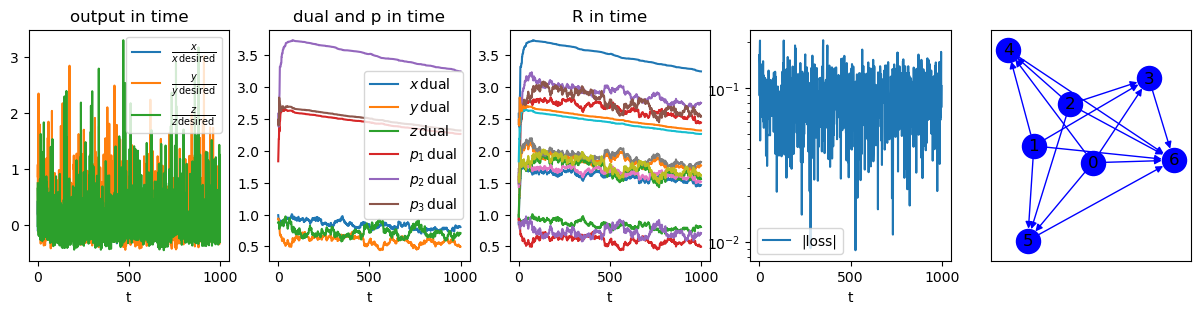

In [17]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

In [18]:
if np.size(State.Power_norm_in_t)>1:
    plot_functions.plot_Power(State)
else:
    pass

### accuracy

In [19]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [20]:
# State.accuracy_in_t

In [21]:
State.output_in_t

[array([1.02862418, 1.02862418, 1.02862418]),
 array([0.45533582, 0.45533582, 0.45533582]),
 array([0.58684765, 0.57410243, 0.55833933]),
 array([0.86817429, 0.83663018, 0.80223137]),
 array([0.64435566, 0.63641131, 0.60430926]),
 array([0.43379385, 0.42971518, 0.41252746]),
 array([0.5955396 , 0.58695006, 0.57906926]),
 array([0.34699823, 0.34215498, 0.33769911]),
 array([0.64150702, 0.6321029 , 0.62432596]),
 array([0.52424235, 0.51636876, 0.50986966]),
 array([0.39972355, 0.39270964, 0.38659832]),
 array([1.21173537, 1.19190549, 1.17452372]),
 array([0.43843788, 0.403146  , 0.3947693 ]),
 array([0.44386517, 0.40702213, 0.39834381]),
 array([0.45068113, 0.41662494, 0.4085134 ]),
 array([0.63184984, 0.57909487, 0.56684377]),
 array([0.70187292, 0.65231396, 0.63972777]),
 array([1.05602757, 0.98243347, 0.96369196]),
 array([0.63254371, 0.56640888, 0.58238174]),
 array([0.23683959, 0.21137137, 0.21749202]),
 array([0.60160619, 0.50729471, 0.56911539]),
 array([0.47340533, 0.3993279 , 0.

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [22]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

u [0.28394681 0.32614317 0.29540127 0.16991407 0.20980458 0.18121171
 0.27398939 0.31663535 0.28565377 0.44132528 0.30793305 0.43121004
 0.72785026 0.8525831  0.76226675]
Rs [1.462565   1.77013566 1.55766935 2.44412173 2.75169238 2.53922607
 1.51571805 1.82328871 1.6108224  2.2659024  3.24745912 2.31905545
 0.8033374  0.49576674 0.70823305]
Power dissipation 3.523168480496499


## Save sizes to file

In [45]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

# loss_mat = np.array([[6.00E-05, 1.20E-03, 2.20E-03, 7.20E-03],[5.00E-05, 0.12, 0.16, 0.15], [2.00E-05, 0.18, 0.16, 0.13], [1.10E-03, 0.049, 0.09, 2.6]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

loss_mat = np.array([[1.8E-14, 1.5E-8, 1.7E-8, 9.7E-6], [1.2E-12, 0.061, 0.12, 0.096], [6.7E-14, 0.061, 0.12, 0.096], [2.1E-8, 0.0089, 0.054, 0.043]])
np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

### Loss afo inputs and outputs

In [47]:
load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/final loss afo Nin Nout normalized loss/'

loss_mat = np.load(load_folder_prelim + 'loss_mat.npy')

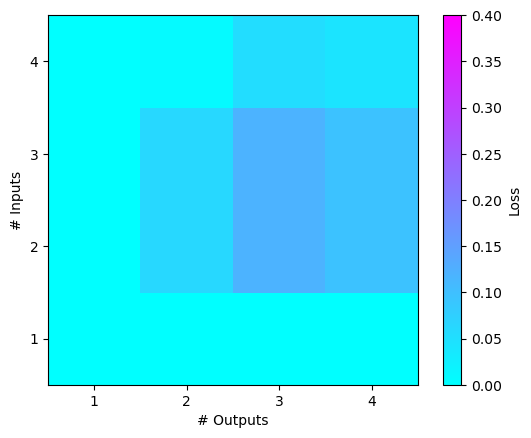

In [50]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(loss_mat)

### R change scheme under 2 tasks

In [26]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

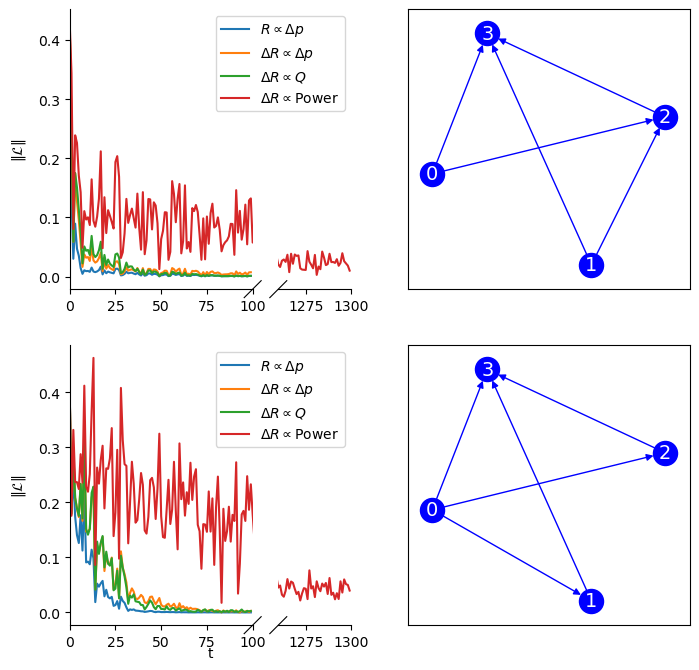

In [27]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [28]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

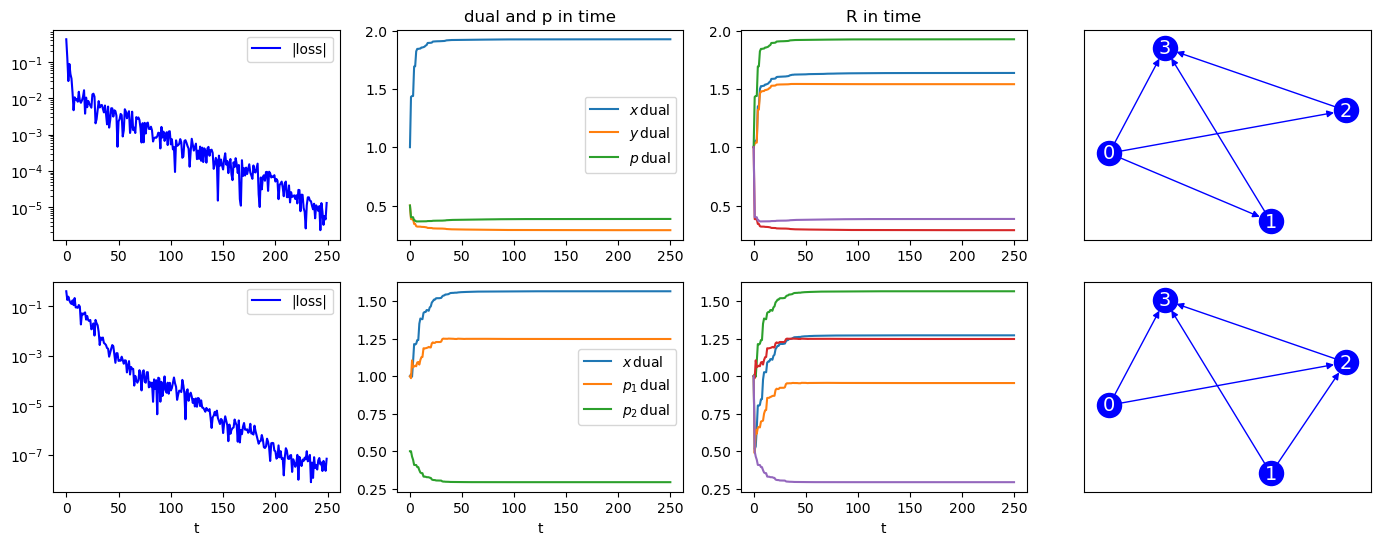

In [29]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

### different R relations

In [30]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [31]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [32]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

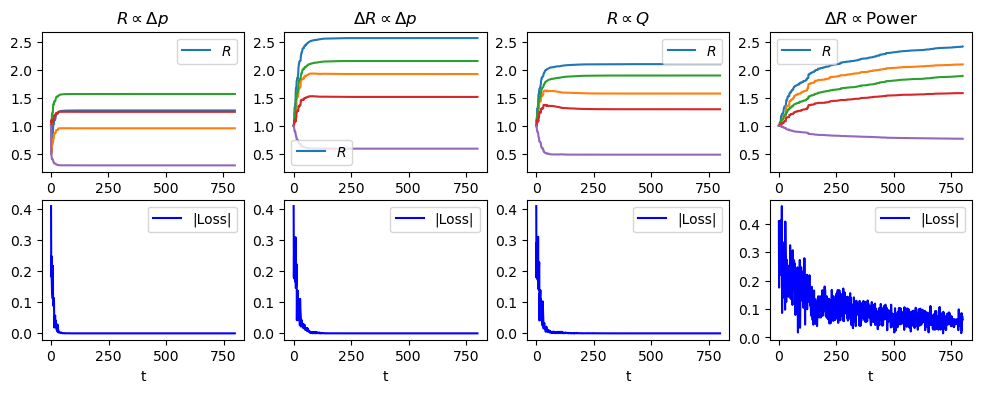

In [33]:
figure_plots.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [34]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [35]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [36]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [37]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

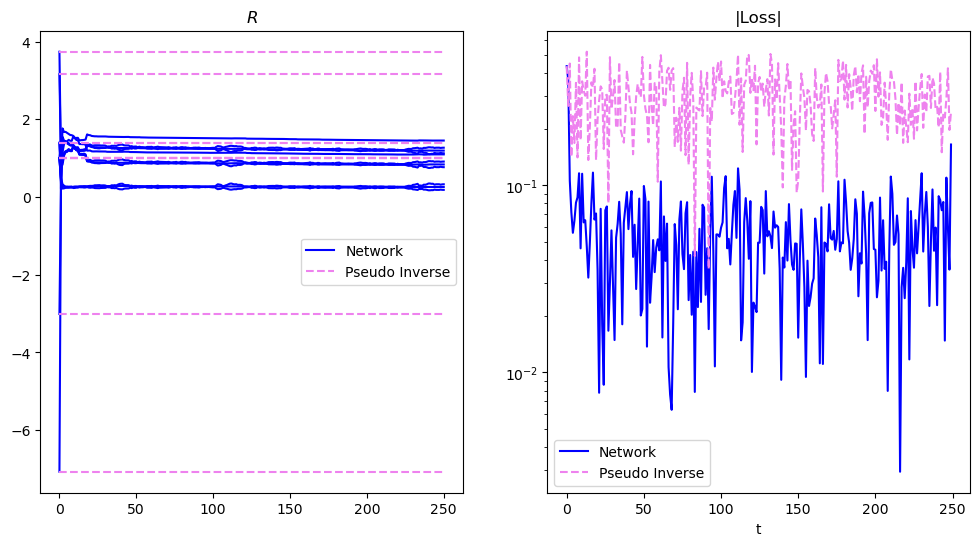

In [38]:
figure_plots.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

In [39]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_final.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/accuracy.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/dataset_len.npy')

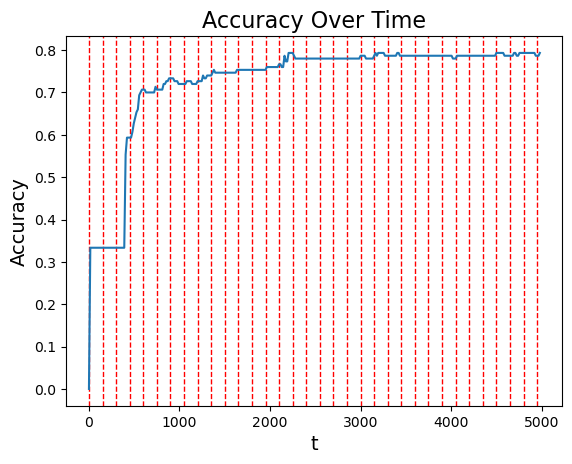

In [40]:
plot_functions.plot_accuracy(t_final, t_for_accuracy, accuracy_in_t, dataset_len)

## Is the network linear?

In [41]:
# # put pressure of 1 through 1st input
# State.input_drawn = np.array([1,0])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 1', State.output)
# out1 = State.output

# # put pressure of 1 through 1st input
# State.input_drawn = np.array([0,1])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 2', State.output)
# out2 = State.output

# print('superpose outputs', out1+out2)

# # put pressure of 1 through inputs
# State.input_drawn = np.ones(Nin)

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output both', State.output)

## Statistics

### Error

In [42]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.16211323475372952


## Checks

In [43]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [44]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)